## Lab 4: Gridded data in Python

**Objectives:**
   * We will learn how to read, inspect, and write gridded data using <code>rasterio</code> and <code>xarray</code>.
   * Learn how to index, slice and manipulate our gridded data.
   * Export our data as <code>GeoTIFF</code> or <code>NetCDF</code> format.

In [28]:
# Import packages
import os
import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import rasterio
import xarray

## Finding day of year
from datetime import datetime, date

## Finding address from coordinates
from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Read and inspect a Landsat 8 raster layer

In [2]:
# Define filepath
filepath = './data/'

# Define list of Landsat bands
files = sorted(glob.glob(filepath + 'landsat/*.tif'))

In [3]:
# Open all bands in a loop
list_bands = []
for file in files:
    # Read band
    src = rasterio.open(file)
    band = src.read(1)
    
    # Append to list
    list_bands.append(band)

# Convert from list of arrays to n-dimensional array
all_bands = np.dstack(list_bands)

In [4]:
# Get corners of dataset
full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

In [5]:
# Convert values to a range of 0-255
all_bands_image = np.uint8((all_bands / 65536) * 255)

In [6]:
# Produce a new array by stacking the RGB bands
rgb = np.dstack((all_bands_image[:,:,3],all_bands_image[:,:,2],all_bands_image[:,:,1]))

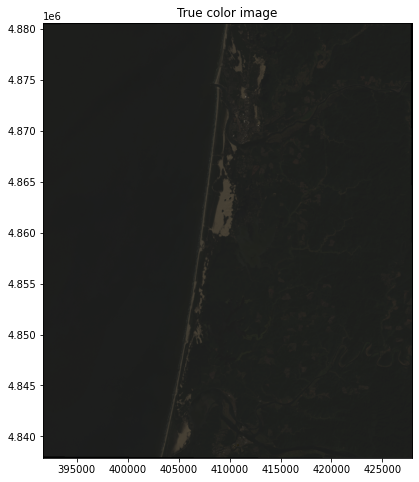

In [7]:
# Produce a new array by stacking the RGB bands
rgb = np.dstack((all_bands_image[:,:,3],all_bands_image[:,:,2],all_bands_image[:,:,1]))

# Plot as RGB image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(rgb, extent=full_extent)
ax.set_title("True color image")
plt.show()

### Compute a band ratio

We can compute a Normalized Difference Water Index (NDWI) using the Green and NIR bands. 

NDWI = (Band 3 - Band 5) / (Band 3 + Band 5)

Remember that arrays are zero indexed, so the first layer is corresponds to <code>all_bands[:,:,0]</code>. Also note that we have to make sure our bands are converted to <code>float</code> datatypes.

In [8]:
# Compute NDWI
np.seterr(divide='ignore', invalid='ignore')
ndwi = np.divide((all_bands[:,:,2].astype(float) - all_bands[:,:,4].astype(float)), \
                 (all_bands[:,:,2].astype(float) + all_bands[:,:,4].astype(float))) # Extra credit for fixing this error...

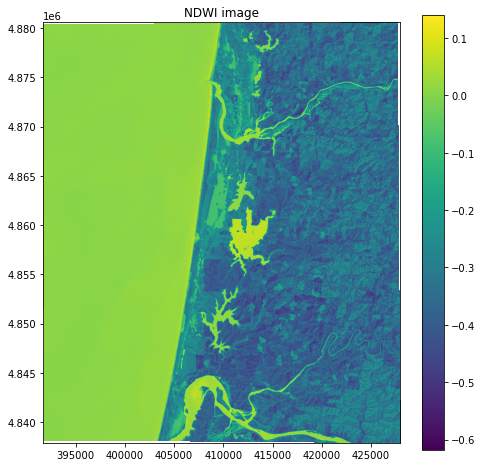

In [9]:
# Compute NDWI
np.seterr(divide='ignore', invalid='ignore')
ndwi = np.divide((all_bands[:,:,2].astype(float) - all_bands[:,:,4].astype(float)), \
                 (all_bands[:,:,2].astype(float) + all_bands[:,:,4].astype(float)))

# Plot NDWI image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(ndwi, extent=full_extent)
ax.set_title("NDWI image")
fig.colorbar(im, orientation='vertical')
plt.show()

### Write true color composite to GeoTIFF

In [10]:
# Write an array as a raster band to a new 8-bit file. For the new file's profile, 
# we start with the profile of the source
profile = src.profile

# And then change the band count to 3, set the dtype to uint8, and specify LZW compression.
profile.update(dtype=rasterio.uint8, count=3, compress='lzw')

In [11]:
with rasterio.open(filepath + 'landsat/rgb.tif', 'w', **profile) as dst:
    # Write array
    dst.write(np.rollaxis(rgb, axis=2)) # Note that array needs to be in bands, rows, cols order (z, y, x)

## Read climate reanalysis data

In [12]:
# Read data
xds = xarray.open_dataset(filepath + 'era/usa_t2m_tcc_2020.nc', decode_coords='all')

In [13]:
xds

<xarray.Dataset>
Dimensions:    (longitude: 233, latitude: 99, time: 1464)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.24 48.99 48.74 48.49 ... 25.24 24.99 24.74
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-12-31T18:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-01-05 17:55:44 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

This looks a bit overwelming but it nice way to store gridded data. Below is a schematic of what an xarray data structure represents.


<br>
<div>
<img src="images/xarray_data_structures.png" width="600"/>
</div>

In [14]:
# Print the time period of the data
print('The data ranges from %s to %s' %(xds['t2m']['time'].values.min(), xds['t2m']['time'].values.max()))

The data ranges from 2020-01-01T00:00:00.000000000 to 2020-12-31T18:00:00.000000000


So we know the data spans one year but there are 1464 dimensions in the time variable. This means that the reanalysis data must have a temporal resolution of 6 hours. So before we continue we will resample to daily temporal resolution.

In [15]:
xds_daily = xds.resample(time='1D').mean()
xds_daily

<xarray.Dataset>
Dimensions:    (time: 366, longitude: 233, latitude: 99)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.24 48.99 48.74 48.49 ... 25.24 24.99 24.74
Data variables:
    t2m        (time, latitude, longitude) float32 280.6 281.4 ... 296.3 296.2
    tcc        (time, latitude, longitude) float32 0.9765 0.8814 ... 0.2124

### Plot climate reanalysis data

Now each layer in the dataset corresponds to a single day. Let's plot the air temperature and cloud cover for the day which the Landsat image was acquired (August 14, 2020).

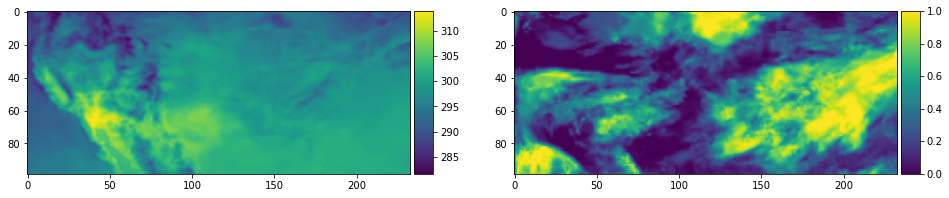

In [16]:
# Plot data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
im1 = ax1.imshow(xds_daily['t2m'][226,:,:])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax2.imshow(xds_daily['tcc'][226,:,:])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

### Weather in Florence, OR

So we know that is was relatively cold, cloud-free day in Florence, just like we see in the Landsat image. But how anomalous were these conditions? We can investigate by finding the nearest climate reanalysis grid cell to Florence, OR. First we will define the latitude and longitude of Florence. 

In [17]:
# Next, find the index of the grid point nearest a specific lat/lon.   
florence_weather = xds_daily.sel(latitude=43.974659, longitude=-124.103142, method='nearest')

In [18]:
# Note: Aug 14 is DOY 226
print('Cloud cover in Florence on Aug 14, 2020 = %.2f %%' % (florence_weather['tcc'][226].values * 100))

Cloud cover in Florence on Aug 14, 2020 = 0.02 %


In [19]:
fahrenheit = (florence_weather['t2m'][226].values - 273.15) * 9/5 + 32
print('Air temperature in Florence on Aug 14, 2020 = %.2f F' % (fahrenheit))

Air temperature in Florence on Aug 14, 2020 = 62.25 F


### Plot time series

These values look about right. Now we can plot the time series.

Text(0, 0.5, 'Cloud cover (%)')

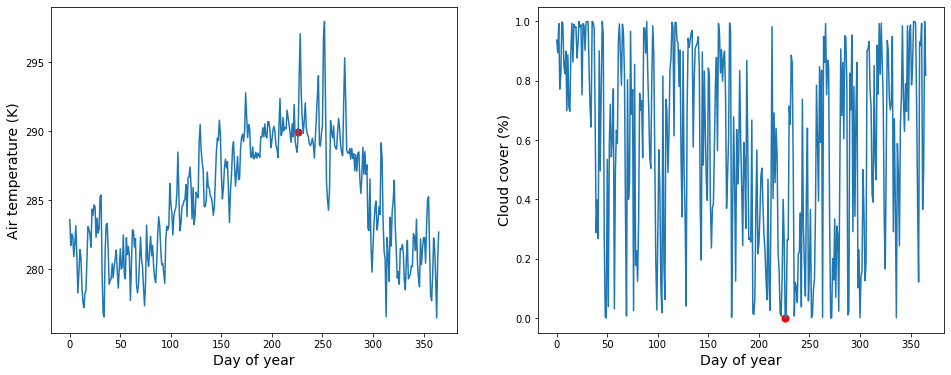

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.plot(florence_weather['t2m'])
ax1.scatter(226, florence_weather['t2m'][226], s=50, color='r')
ax1.set_xlabel('Day of year', fontsize=14)
ax1.set_ylabel('Air temperature (K)', fontsize=14)

ax2.plot(florence_weather['tcc'])
ax2.scatter(226, florence_weather['tcc'][226], s=50, color='r')
ax2.set_xlabel('Day of year', fontsize=14)
ax2.set_ylabel('Cloud cover (%)', fontsize=14)

### Find mean values

It was a pretty nice warm day in Florence on Aug 14, 2020 relative to mean annual conditions. But what is the actual mean?

In [21]:
mean_temp = (florence_weather['t2m'].mean() - 273.15) * 9/5 + 32
print('Mean air temp. in Florence in 2020 = %.2f F' % (mean_temp))

Mean air temp. in Florence in 2020 = 53.55 F


In [22]:
mean_temp = (florence_weather['t2m'].mean() - 273.15) * 9/5 + 32
print('Mean air temp. in Florence in 2020 = %.2f F' % (mean_temp))

mean_cloud = florence_weather['tcc'].mean()
print('Mean cloud cover in Florence in 2020 = %.2f %%' % (mean_cloud * 100))

Mean air temp. in Florence in 2020 = 53.55 F
Mean cloud cover in Florence in 2020 = 58.76 %


Finally, let's calculate how many days had less than 20% cloud cover in Florence

In [23]:
days = np.sum(florence_weather['tcc'] < 0.2).values
print('There were %.0f days with less than 20%% cloud cover in 2020' % days)

There were 61 days with less than 20% cloud cover in 2020


***********
## Question 1 (20 points):  

Display the Landsat image of Florence, OR as:

* a) a **color infrared composite** (i.e. bands 5, 4, 3)
* b) an **NDVI** image (i.e. (Band 5 - Band 4) / (Band 5 + Band 4))

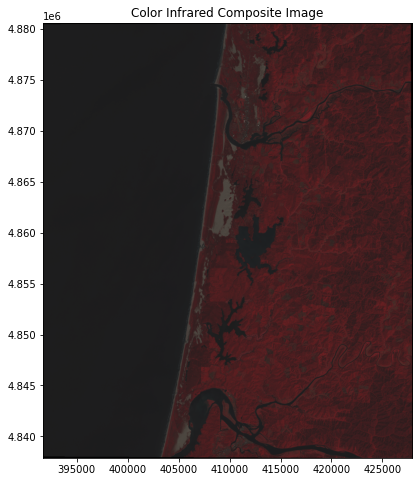

In [24]:
# Produce a new array by stacking the RGB bands
inf_comp = np.dstack((all_bands_image[:,:,4],all_bands_image[:,:,3],all_bands_image[:,:,2]))

# Plot as RGB image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(inf_comp, extent=full_extent)
ax.set_title("Color Infrared Composite Image")
plt.show()

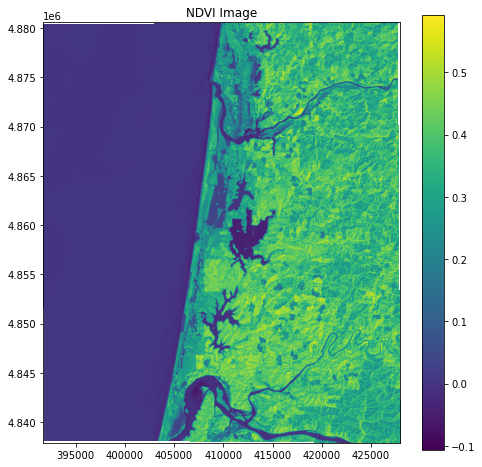

In [25]:
# Compute NDWI
np.seterr(divide='ignore', invalid='ignore')
ndvi = np.divide((all_bands[:,:,4].astype(float) - all_bands[:,:,3].astype(float)), \
                 (all_bands[:,:,4].astype(float) + all_bands[:,:,3].astype(float)))

# Plot NDWI image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(ndvi, extent=full_extent)
ax.set_title("NDVI Image")
fig.colorbar(im, orientation='vertical')
plt.show()

*******
## Question 2 (10 points):

Find the following numbers in the climate reanalysis dataset:

* a) the air temperature (in F) **and** cloud cover (in %) in Florence, OR (in 2020) on **January 31, 2020**?
* b) the air temperature (in F) **and** cloud cover (in %) in **Eugene, OR** (in 2020) on **February 15, 2020**?

You can use the following table to convert from a **date** to a **day-of-year**: https://landweb.modaps.eosdis.nasa.gov/browse/calendar.html

In [26]:
# Specific date
day_of_year_1 = date(2020, 1, 31).timetuple().tm_yday
print("Day of year: ", day_of_year_1)

mean_temp = (florence_weather['t2m'][day_of_year_1].mean() - 273.15) * 9/5 + 32
print('Mean air temp. in Florence in 2020 = %.2f F' % (mean_temp))
mean_cloud = florence_weather['tcc'].mean()
print('Mean cloud cover in Florence in 2020 = %.2f %%' % (mean_cloud * 100), "\n")

# Next, find the index of the grid point nearest a specific lat/lon.   
eugene_weather = xds_daily.sel(latitude=44.0521, longitude=-123.0868, method='nearest')

day_of_year_2 = date(2020, 2, 15).timetuple().tm_yday
print("Day of year: ", day_of_year_2)

mean_temp = (eugene_weather['t2m'][day_of_year_2].mean() - 273.15) * 9/5 + 32
print('Mean air temp. in Eugene on February 15, 2020 = %.2f F' % (mean_temp))
mean_cloud = eugene_weather['tcc'][day_of_year_2].mean()
print('Mean cloud cover in Eugene on February 15, 2020 = %.2f %%' % (mean_cloud * 100))

Day of year:  31
Mean air temp. in Florence in 2020 = 54.04 F
Mean cloud cover in Florence in 2020 = 58.76 % 

Day of year:  46
Mean air temp. in Eugene on February 15, 2020 = 43.79 F
Mean cloud cover in Eugene on February 15, 2020 = 97.51 %


**********

## Question 3 (20 points): 

Find the following grid cells in the climate reanalysis dataset and provide a rough location of where they are located. 

* a) Highest average air temperature (i.e. hottest place)
* b) Lowest average air temperature (i.e. coldest place)
* c) Highest average cloudiness (i.e. cloudiest place)
* d) Lowest average cloudiest (i.e. least cloudy place)
* e) Place with highest range in air temperature
* f) Place with the absolute coldest temperature on a single day 

You can use the following link to convert your lat/lons to an address: https://www.latlong.net/Show-Latitude-Longitude.html

In [64]:
max_value = np.mean(xds_daily['t2m'], axis=0).argmax()
index = np.unravel_index(max_value, np.mean(xds_daily['t2m'], axis=0).shape)
lat, lon = xds_daily.latitude[index[0]], xds_daily.longitude[index[1]]

geocoder = Nominatim(user_agent="jsheppar@uoregon.edu")
location_list = geocoder.reverse((lat,lon))
location = location_list[0]
print("The location with the highest average temperature is: %s" %location)

The location with the highest average temperature is: Granja Guadalupe, Hermosillo, Sonora, México


In [66]:
min_value = np.mean(xds_daily['t2m'], axis=0).argmin()
index = np.unravel_index(min_value, np.mean(xds_daily['t2m'], axis=0).shape)
lat, lon = xds_daily.latitude[index[0]], xds_daily.longitude[index[1]]

location_list = geocoder.reverse((lat,lon))
location = location_list[0]
print("The location with the lowest average temperature is: %s" %location)

The location with the lowest average temperature is: Park County, Wyoming, United States


In [67]:
max_value = np.mean(xds_daily['tcc'], axis=0).argmax()
index = np.unravel_index(max_value, np.mean(xds_daily['t2m'], axis=0).shape)
lat, lon = xds_daily.latitude[index[0]], xds_daily.longitude[index[1]]

location_list = geocoder.reverse((lat,lon))
location = location_list[0]
print("The location with the highest average total cloud cover is: %s" %location)

The location with the highest average total cloud cover is: Stirling Arm Road, Area D (Sproat Lake), British Columbia, Canada


In [79]:
min_value = np.mean(xds_daily['tcc'], axis=0).argmin()
index = np.unravel_index(min_value, np.mean(xds_daily['tcc'], axis=0).shape)
lat, lon = xds_daily.latitude[index[0]], xds_daily.longitude[index[1]]

location_list = geocoder.reverse((lat,lon))
location = location_list[0]
print("The location with the lowest average total cloud cover is: %s" %location)

The location with the lowest average total cloud cover is: México


In [107]:
# max_value = (xds_daily['t2m'][:,:,0].argmax() - xds_daily['t2m'][:,:,0].argmin()).argmax()
# index = np.unravel_index(max_value, np.mean(xds_daily['t2m'], axis=0).shape)
# lat, lon = xds_daily.latitude[index[0]], xds_daily.longitude[index[1]]

min_value = (xds_daily.t2m.argmax(...) - xds_daily.t2m.argmin(...)).argmax(...)
lat, lon = xds_daily.latitude[2], xds_daily.longitude[55]

location_list = geocoder.reverse((lat,lon))
location = location_list[0]
print("The location with the highest range in temperature is: %s" %location)

TypeError: unsupported operand type(s) for -: 'dict' and 'dict'

In [112]:
min_value = xds_daily.t2m.argmin(...)
print(min_value.get('latitude'))
# lat, lon = xds_daily.latitude[2], xds_daily.longitude[55]

# location_list = geocoder.reverse((lat,lon))
# location = location_list[0]
# print("The location with the lowest absolute temperature is: %s" %location)

<xarray.DataArray 't2m' ()>
array(2)
